In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import ttest_ind


df = pd.read_csv(r"F:\Apps\PythonProjects\requst\Yandex\ecom_yl.csv")

#изменение названий  столбцов согласно PEP8
df.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)
df.rename(columns={'sessiondurationsec': 'session_duration_sec'}, inplace=True)

#перевод в нужные типы данных
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['session_duration_sec'] = df['session_duration_sec'].apply(lambda x: round(x) if pd.notnull(x) else x)

#исправление строковых данных, перевод в общий вид
df.loc[df['region'] == 'germany', 'region'] = 'Germany'
df.loc[df['region'] == 'Frаnce', 'region'] = 'France'
df.loc[df['region'] == 'France', 'region'] = 'France'
df.loc[df['region'] == 'Frаncе', 'region'] = 'France'
df.loc[df['region'] == 'Franсe', 'region'] = 'France'
df.loc[df['region'] == 'Unjted States', 'region'] = 'United States'
df.loc[df['region'] == 'UK', 'region'] = 'UK'
df.loc[df['region'] == 'UК', 'region'] = 'UK'
df.loc[df['device'] == 'android', 'device'] = 'Android'
df.loc[df['channel'] == 'контексная реклама', 'channel'] = 'контекстная реклама'

#перевод значений столбца промокод в бинарный столбце
df.loc[~df['promo_code'].isin([1, 0, np.nan]), 'promo_code'] = 0

print(df.describe(),'\n\nИсходя из describe по столбцу revenue можно заметить аномальные значения 1 и 100000')

#при просмотре данных было выявоено, что пропуски в столбцах region,channel, device можно заменить значениями, тк пропуски в этих столбцах являются вторым заходом пользователей
df['region'].fillna(df.groupby('user_id')['region'].transform('first'), inplace=True)
df['channel'].fillna(df.groupby('user_id')['channel'].transform('first'), inplace=True)
df['device'].fillna(df.groupby('user_id')['device'].transform('first'), inplace=True)

df = df.loc[~df['revenue'].isin([1, 100000])]

df = df.drop_duplicates()


#Перевод часов в время суток
def get_time_of_day(hour):
    if 6 <= hour <= 9:
        return 'утро'
    elif 10 <= hour <= 16:
        return 'день'
    elif 17 <= hour <= 21:
        return 'вечер'
    else:
        return 'ночь'

#Добавление новых столбцов согласно тз + столбцы для помощи в расчетах
df['time_of_day'] = df['hour_of_day'].apply(get_time_of_day)
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)
df['final_revenue'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df_channel = df.loc[df['channel'] != 'organic']

            user_id  session_duration_sec        month          day  \
count  1.012000e+03           1012.000000  1012.000000  1012.000000   
mean   5.058761e+11           1822.203557     7.662055     4.053360   
std    2.947829e+11           1835.461078     1.693773     2.059721   
min    7.687107e+08              0.000000     5.000000     1.000000   
25%    2.464855e+11            535.500000     6.000000     2.000000   
50%    5.011254e+11           1230.500000     8.000000     4.000000   
75%    7.704731e+11           2526.250000     9.000000     6.000000   
max    9.999447e+11          12388.000000    10.000000     7.000000   

       hour_of_day        revenue  promo_code  
count  1012.000000     285.000000  285.000000  
mean     11.475296    6862.185965    0.287719  
std       6.912222   11212.159106    0.453496  
min       0.000000       1.000000    0.000000  
25%       6.000000    4999.000000    0.000000  
50%      11.000000    4999.000000    0.000000  
75%      18.000000    59

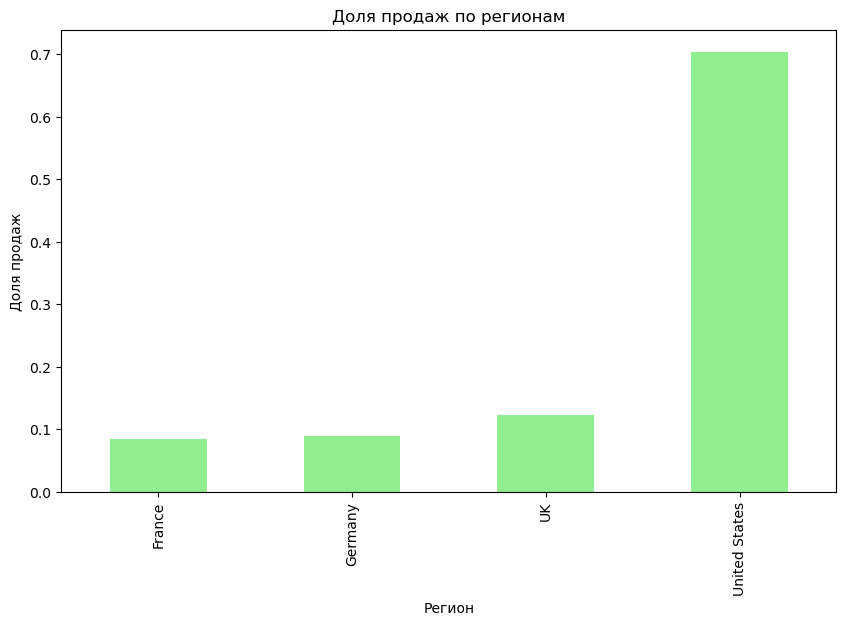

большая доля продаж приходится на United States


In [2]:
# График доли продаж по регионам
sales_by_source = df.groupby('region')['final_revenue'].sum()
total_sales_region = sales_by_source.sum()
sales_share_source = sales_by_source / total_sales_region

plt.figure(figsize=(10, 6))
sales_share_source.plot(kind='bar', color='lightgreen')

plt.title('Доля продаж по регионам')
plt.xlabel('Регион')
plt.ylabel('Доля продаж')
plt.show()
print('большая доля продаж приходится на United States')

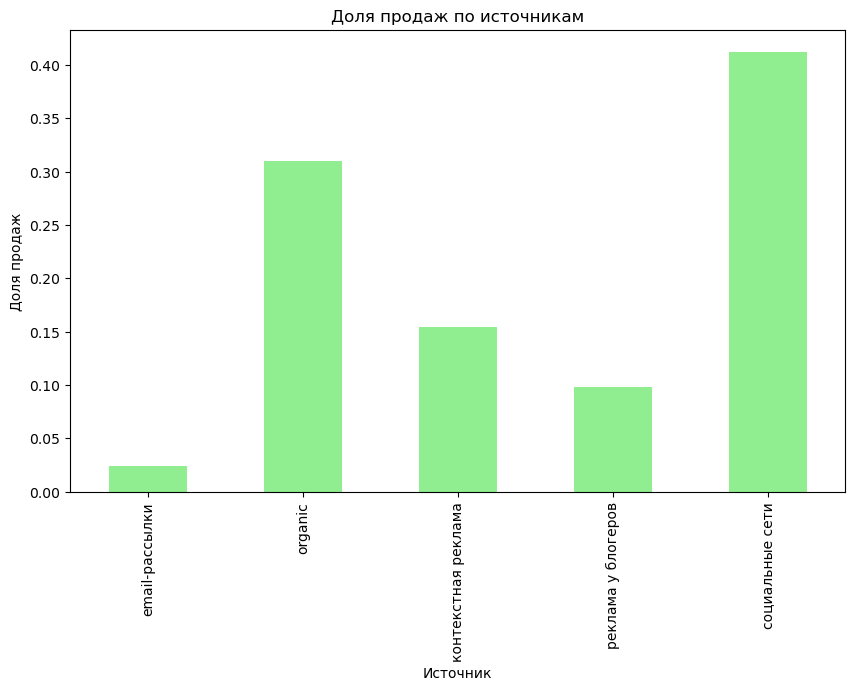

большая доля продаж приходится на социальные сети


In [3]:
# График доли продаж по источникам
sales_by_source = df.groupby('channel')['final_revenue'].sum()
total_sales_source = sales_by_source.sum()
sales_share_source = sales_by_source / total_sales_source

plt.figure(figsize=(10, 6))
sales_share_source.plot(kind='bar', color='lightgreen')
plt.title('Доля продаж по источникам')
plt.xlabel('Источник')
plt.ylabel('Доля продаж')
plt.show()
print('большая доля продаж приходится на социальные сети')

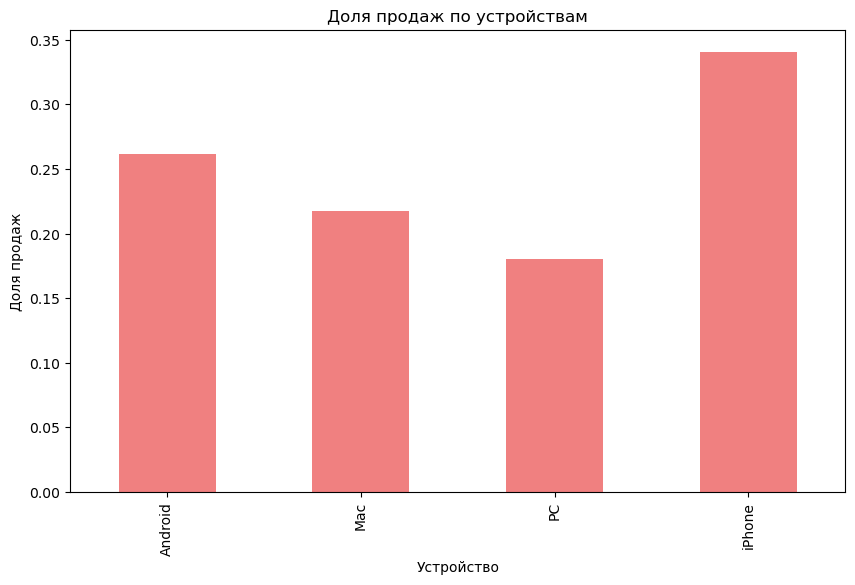

график показывает, что большинство покупок было совершенно с iPhone


In [4]:
# График доли продаж по устройствам
sales_by_device = df.groupby('device')['final_revenue'].sum()
total_sales_device = sales_by_device.sum()
sales_share_device = sales_by_device / total_sales_device

plt.figure(figsize=(10, 6))
sales_share_device.plot(kind='bar', color='lightcoral')
plt.title('Доля продаж по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Доля продаж')
plt.show()
print('график показывает, что большинство покупок было совершенно с iPhone')

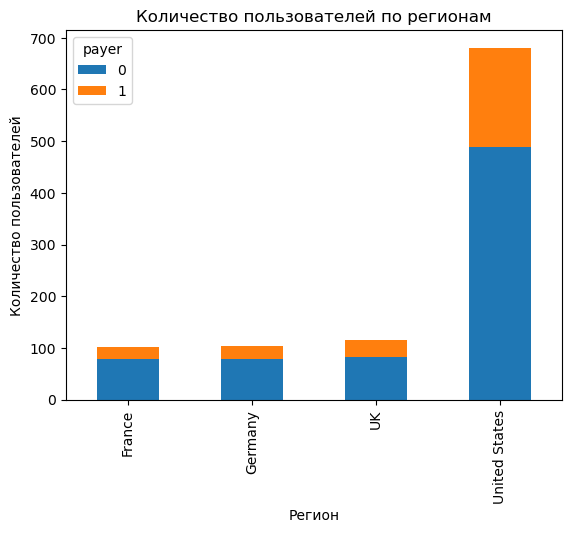

Insight: главная аудитория нашего сайта - пользователи из United States


In [5]:
# График: Количество пользователей с разбивкой на платящих/не платящих по регионам
user_count_region = df.groupby(['region', 'payer'])['user_id'].count().unstack()
user_count_region.plot(kind='bar', stacked=True)
plt.title('Количество пользователей по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.show()
print('Insight: главная аудитория нашего сайта - пользователи из United States')

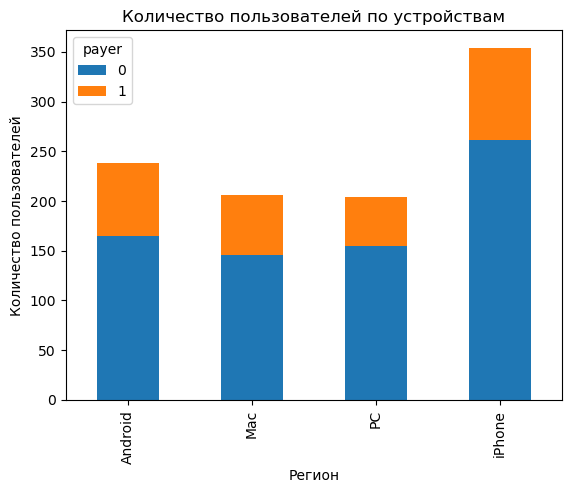

Insight: большинство пользователей использует iPhone


In [6]:
# График: Количество пользователей с разбивкой на платящих/не платящих по регионам
user_count_region = df.groupby(['device', 'payer'])['user_id'].count().unstack()
user_count_region.plot(kind='bar', stacked=True)
plt.title('Количество пользователей по устройствам')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.show()
print('Insight: большинство пользователей использует iPhone')

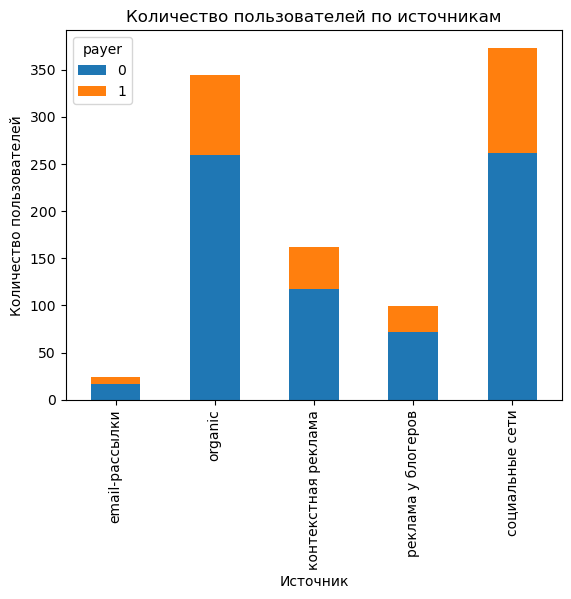

Insight: самый результативнай рекламный канал:
 - социальные сети
самым не результативный рекламный канал:
 - email-рассылки


In [7]:
# График: Количество пользователей с разбивкой на платящих/не платящих по исчточникам

user_count_region = df.groupby(['channel', 'payer'])['user_id'].count().unstack()
user_count_region.plot(kind='bar', stacked=True)
plt.title('Количество пользователей по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.show()

print('Insight: самый результативнай рекламный канал:\n - социальные сети\nсамым не результативный рекламный канал:\n - email-рассылки')

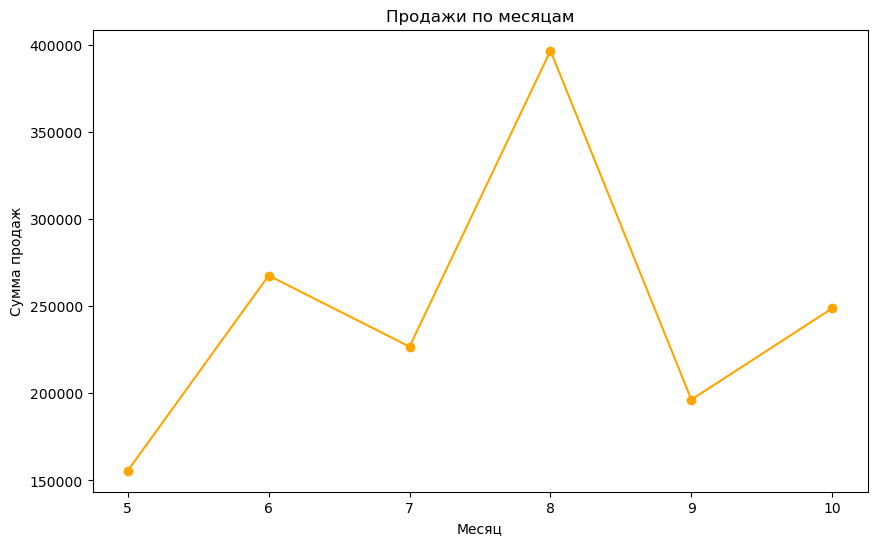

Insight: на графике видна сезонность, больше всего прибыли наша компания получила в августе


In [8]:
# График показывающий сезонность в продажах по месяцам
sales_by_month = df.groupby('month')['final_revenue'].sum()
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='line', marker='o', color='orange')
plt.title('Продажи по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж')
plt.show()
print('Insight: на графике видна сезонность, больше всего прибыли наша компания получила в августе')

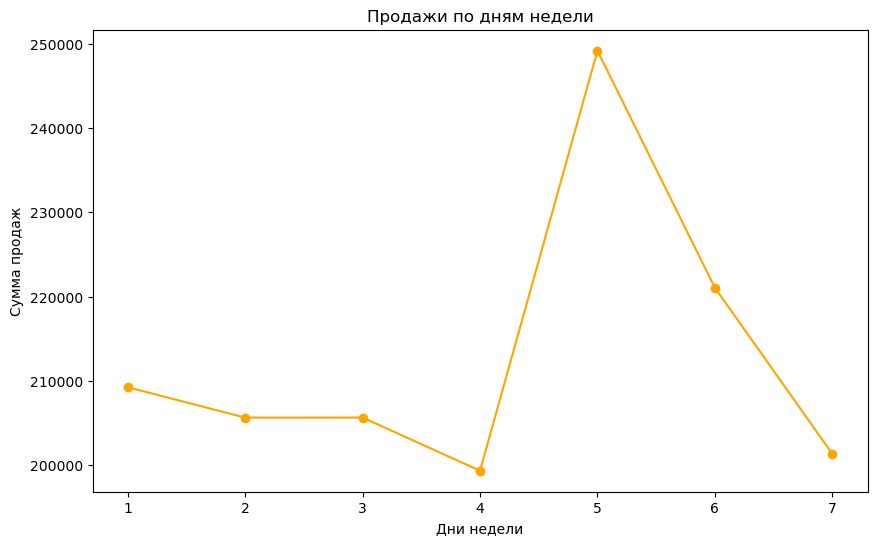

Insight: пользователи совершают закупки перед выходными(дневная сезонность)


In [9]:
# График показывающий сезонность в продажах по дням недели
sales_by_month = df.groupby('day')['final_revenue'].sum()
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='line', marker='o', color='orange')
plt.title('Продажи по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Сумма продаж')
plt.show()
print('Insight: пользователи совершают закупки перед выходными(дневная сезонность)')

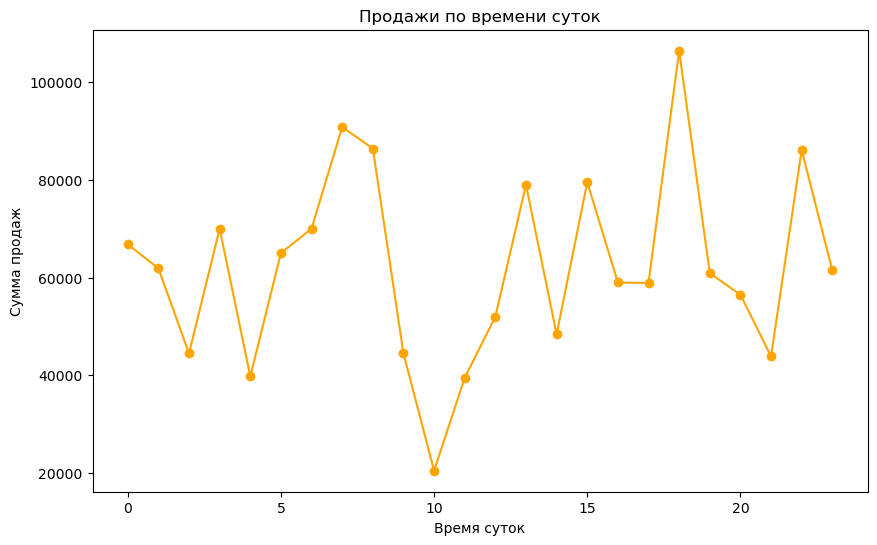

Insight: исходя из графика можно определить время активности платящих пользователй:
  1)утро(5-10ч)
  2)вечер(17-18ч)
Так же заметен сильный спад активности в 10ч


In [10]:
# График показывающий сезонность в продажах по времени суток
sales_by_month = df.groupby('hour_of_day')['final_revenue'].sum()
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='line', marker='o', color='orange')
plt.title('Продажи по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Сумма продаж')
plt.show()
print('Insight: исходя из графика можно определить время активности платящих пользователй:\n  1)утро(5-10ч)\n  2)вечер(17-18ч)\nТак же заметен сильный спад активности в 10ч')

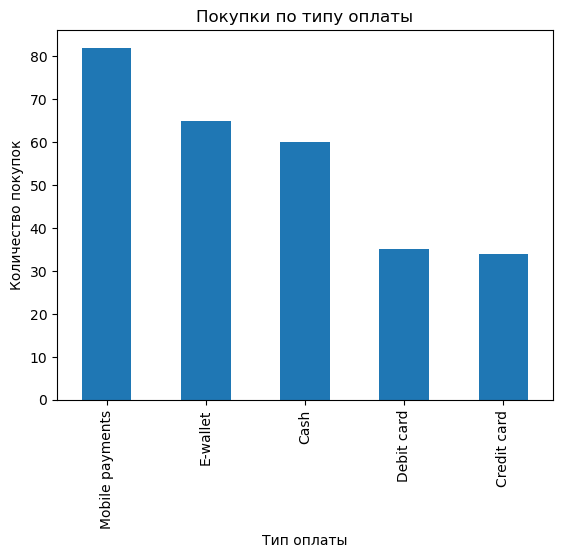

Insight: большинство пользователей предпочинают оплату мобильными платежами


In [11]:
# Диаграмма количества покупок по типу оплаты
payment_counts = df['payment_type'].value_counts()
payment_counts.plot(kind='bar')
plt.title('Покупки по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество покупок')
plt.show()
print('Insight: большинство пользователей предпочинают оплату мобильными платежами')

In [12]:
# Рассчитать средний чек
average_check = df['final_revenue'].mean()
print("Средний чек:", round(average_check))

Средний чек: 5404


In [13]:
# Сколько покупок в среднем совершает 1 пользователь?
average_purchases_per_user = df.groupby('user_id')['revenue'].count().mean()
print("Покупки 1 пользователем:") 
round(average_purchases_per_user,1)

Покупки 1 пользователем:


0.3

In [14]:
# Рассчитать среднюю продолжительность сессии по рекламным каналам.
df_channel = df.loc[df['channel'] != 'organic']
average_session_duration = df_channel.groupby('channel')['session_duration_sec'].median().reset_index()

print("средняя продолжительность сессии по рекламным каналам:\n")
print("Insight: исходя из данного расчета можно сделать вывод: email-рассылки лучше других рекламных каналов удерживают пользователей на сайте\n ")
average_session_duration

средняя продолжительность сессии по рекламным каналам:

Insight: исходя из данного расчета можно сделать вывод: email-рассылки лучше других рекламных каналов удерживают пользователей на сайте
 


,channel,session_duration_sec
0,email-рассылки,1269.5
1,контекстная реклама,1451.0
2,реклама у блогеров,1308.0
3,социальные сети,1215.0


In [17]:
# Определить топ-3 региона по среднему чеку
region_avg_revenue = df.groupby('region')['final_revenue'].mean().round()
top_regions = region_avg_revenue.sort_values(ascending=False)
top_3_regions = top_regions.head(3).reset_index()
print("Топ-3 регионов по среднему чеку:")
top_3_regions

Топ-3 регионов по среднему чеку:


,region,final_revenue
0,UK,5508.0
1,United States,5423.0
2,Germany,5331.0


In [18]:
# Определить топ-3 месяца по среднему чеку с разбивкой по регионам
top_3_months = df.groupby(['month', 'region'])['revenue'].mean().nlargest(3)
print("топ-3 месяца по среднему чеку с разбивкой по регионам.:", top_3_months)

топ-3 месяца по среднему чеку с разбивкой по регионам.: month  region       
7      Germany          7499.000000
5      United States    6449.000000
10     UK               6141.857143
Name: revenue, dtype: float64


In [19]:
# Посчитать MAU* по каждому месяцу с разбивкой по рекламным каналам и выделить топ-3 рекламных каналов по количеству уникальных пользователей в месяц
df['Month'] = df['session_date'].dt.to_period('M')

mau_data = df_channel.groupby(['month', 'channel'])['user_id'].nunique().reset_index()


def top_3_channels(data):
    return data.nlargest(3, 'user_id')


top_channels_per_month = mau_data.groupby('month', as_index=False).apply(top_3_channels)
top_channels_per_month

month              channel  user_id
0 3       5      социальные сети       40
  2       5   реклама у блогеров       12
  1       5  контекстная реклама        8
1 7       6      социальные сети       53
  5       6  контекстная реклама       28
  6       6   реклама у блогеров       13
2 11      7      социальные сети       57
  9       7  контекстная реклама       24
  10      7   реклама у блогеров       16
3 15      8      социальные сети       68
  13      8  контекстная реклама       37
  14      8   реклама у блогеров       20
4 19      9      социальные сети       67
  17      9  контекстная реклама       38
  18      9   реклама у блогеров       20
5 23     10      социальные сети       85
  21     10  контекстная реклама       27
  22     10   реклама у блогеров       18

In [20]:
filtered_df = df[df['revenue'] > 0]
grouped = df.groupby('channel')
new_df = pd.DataFrame()
new_df['Количество пользователей'] = grouped['user_id'].count()
new_df['Количество уникальных пользователей'] = grouped['user_id'].nunique()
grouped_filtered = filtered_df.groupby('channel')
new_df['Количество платящих пользователей'] = grouped_filtered['user_id'].nunique()
new_df['Сумма продаж'] = grouped['revenue'].sum()
max_paying_users_channel = new_df['Количество платящих пользователей'].idxmax()
max_sales_channel = new_df['Сумма продаж'].idxmax()
print(f'Канал с наибольшим количеством платящих пользователей: {max_paying_users_channel}')
print(f'Канал с наибольшей суммой продаж: {max_sales_channel}')
new_df

Канал с наибольшим количеством платящих пользователей: социальные сети
Канал с наибольшей суммой продаж: социальные сети


,Количество пользователей,Количество уникальных пользователей,Количество платящих пользователей,Сумма продаж
channel,,,,
email-рассылки,24,23,6,37993.0
organic,344,343,84,475915.0
контекстная реклама,162,159,42,238955.0
реклама у блогеров,99,98,27,147973.0
социальные сети,373,368,111,629889.0


In [23]:
# Составить таблицу в которой будет указано по рекламным каналам: количество пользователей, количество уникальных пользователей, количество платящих пользователей, сумма продаж и определить какой источника “принес” больше всего платящих пользователей и большую сумму продаж.
grouped_data = df.groupby("channel")

In [24]:
# Рассчитаем необходимые метрики
num_users = grouped_data["user_id"].count()
num_unique_users = grouped_data["user_id"].nunique()
num_paying_users = grouped_data["payment_type"].count()
sales_amount = grouped_data["revenue"].sum()
table= pd.DataFrame({
    "Количество пользователей": num_users,
    "Количество уникальных пользователей": num_unique_users,
    "Количество платящих пользователей": num_paying_users,
    "Объем продаж": sales_amount
})
max_paying_users = table["Количество платящих пользователей"].idxmax()
max_sales_amount = table["Объем продаж"].idxmax()
print(table)
print("\nРекламный канал с самыми платящими пользователями:", max_paying_users)
print("Рекламный канал с наибольшим объемом продаж:", max_sales_amount)


                     Количество пользователей  \
channel                                         
email-рассылки                             24   
organic                                   344   
контекстная реклама                       162   
реклама у блогеров                         99   
социальные сети                           373   

                     Количество уникальных пользователей  \
channel                                                    
email-рассылки                                        23   
organic                                              343   
контекстная реклама                                  159   
реклама у блогеров                                    98   
социальные сети                                      368   

                     Количество платящих пользователей  Объем продаж  
channel                                                               
email-рассылки                                       7       37993.0  
organic               

In [25]:
# Влияет ли тип устройства на количество покупок в день по каждому региону?
regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df['payer'] == 1)]
    reg = region_data.groupby('session_date')['payer'].count().reset_index(name='count')
    devices = region_data['device'].unique()
    for device in devices:
        data = region_data[region_data['device'] != device].groupby('session_date')['payer'].count().reset_index(name='count')['count']
        statistic, pvalue = ttest_ind(reg['count'], data)
        if pvalue < 0.05:
            print('Влияет:', region, device, statistic, pvalue)
        else:
            print('Не влияет:', region, device, statistic, pvalue)
    print()


Влияет: United States iPhone 2.3292569331662833 0.02093715536387614
Не влияет: United States Android 1.2787358663242443 0.20253354381744304
Не влияет: United States PC 0.7647217180617345 0.44532097512551794
Не влияет: United States Mac 1.8846108780787216 0.060947458823781435

Не влияет: France Android -0.47140452079103184 0.6403628893531503
Не влияет: France PC 1.1911838308669727 0.24159705542813267
Не влияет: France Mac 1.3443649330337089 0.1865982908626328
Не влияет: France iPhone -0.0978349010482737 0.9225520034311172

Не влияет: Germany Mac 0.3552399269486911 0.7242762822658404
Не влияет: Germany PC 0.7771684249184551 0.44200017811359604
Не влияет: Germany Android 0.09959963944995869 0.9212147607456818
Не влияет: Germany iPhone 0.7180786296659408 0.47734334949028134

Не влияет: UK PC 0.13129042838416627 0.8961307903186783
Не влияет: UK Android 0.238202524453323 0.8127594964590146
Не влияет: UK Mac 0.46369827369217415 0.6448369828353577
Не влияет: UK iPhone 0.288038180372123 0.77455

C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\3752209719.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)
C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\3752209719.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)


In [29]:
# Влияет ли тип рекламного канала на количество покупок в день по каждому региону?
regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df['payer'] == 1)]
    reg = region_data.groupby('session_date')['payer'].count().reset_index(name='count')
    channels = region_data['channel'].unique()
    for channel in channels:
        data = region_data[region_data['channel'] != channel].groupby('session_date')['payer'].count().reset_index(name='count')['count']
        statistic, pvalue = ttest_ind(reg['count'], data)
        if pvalue < 0.05:
            print('Влияет:', region, channel, statistic, pvalue)
        else:
            print('Не влияет:', region, channel, statistic, pvalue)
    print()


Влияет: United States социальные сети 3.0956018243491576 0.002308166480145243
Не влияет: United States organic 1.8137669993895271 0.07133397811763714
Не влияет: United States реклама у блогеров 0.11251513967758538 0.9105245309831759
Не влияет: United States контекстная реклама 0.15413845074139101 0.8776500223601711

Не влияет: France email-рассылки -0.20663162684711092 0.8374007700309376
Не влияет: France organic -0.0978349010482737 0.9225520034311172
Не влияет: France контекстная реклама 1.0627378626481134 0.2958554645227888
Не влияет: France реклама у блогеров -0.32956863892669835 0.7436358891396871

Не влияет: Germany organic 0.7180786296659408 0.47734334949028134
Не влияет: Germany email-рассылки -0.05998390891441418 0.9524598843521582
Не влияет: Germany реклама у блогеров -0.41643317870731394 0.6795655153072544
Не влияет: Germany контекстная реклама 0.5903418374423854 0.558865180341547

Не влияет: UK organic 1.1558226753579284 0.2532469536422574
Не влияет: UK реклама у блогеров -0

C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\1350358427.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)


In [28]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от региона?
regions = df['region'].unique()
channels = df['channel'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df['payer'] == 1)]
    reg = region_data.groupby('session_date')['payer'].count().reset_index(name='count')
    channels = region_data['channel'].unique()
    for channel in channels:
        data = region_data[region_data['channel'] != channel].groupby('session_date')['payer'].count().reset_index(name='count')['count']
        statistic, pvalue = ttest_ind(reg['count'], data)
        if pvalue < 0.05:
            print('Влияет:', region, channel, statistic, pvalue)
        else:
            print('Не влияет:', region, channel, statistic, pvalue)
    print()


Влияет: United States социальные сети 3.0956018243491576 0.002308166480145243
Не влияет: United States organic 1.8137669993895271 0.07133397811763714
Не влияет: United States реклама у блогеров 0.11251513967758538 0.9105245309831759
Не влияет: United States контекстная реклама 0.15413845074139101 0.8776500223601711

Не влияет: France email-рассылки -0.20663162684711092 0.8374007700309376
Не влияет: France organic -0.0978349010482737 0.9225520034311172
Не влияет: France контекстная реклама 1.0627378626481134 0.2958554645227888
Не влияет: France реклама у блогеров -0.32956863892669835 0.7436358891396871

Не влияет: Germany organic 0.7180786296659408 0.47734334949028134
Не влияет: Germany email-рассылки -0.05998390891441418 0.9524598843521582
Не влияет: Germany реклама у блогеров -0.41643317870731394 0.6795655153072544
Не влияет: Germany контекстная реклама 0.5903418374423854 0.558865180341547

Не влияет: UK organic 1.1558226753579284 0.2532469536422574
Не влияет: UK реклама у блогеров -0

C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\2857722640.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)


In [27]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?
regions = df['region'].unique()
channels = df['channel'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df['payer'] == 1)]
    reg = region_data.groupby('session_date')['payer'].count().reset_index(name='count')
    for channel in channels:
        data = region_data[region_data['channel'] == channel].groupby('session_date')['payer'].count().reset_index(name='count')['count']
        statistic, pvalue = ttest_ind(reg['count'], data)
        if pvalue < 0.05:
            print('Влияет:', region, channel, statistic, pvalue)
        else:
            print('Не влияет:', region, channel, statistic, pvalue)
    print()


Не влияет: United States социальные сети 1.8623495004408692 0.06422067889778157
Влияет: United States organic 3.3155903095555637 0.0011374476930952576
Не влияет: United States реклама у блогеров 1.8000289024895224 0.07454802056712205
Не влияет: United States контекстная реклама 1.2697242476099102 0.20688696600315118
Не влияет: United States email-рассылки nan nan
Не влияет: United States None nan nan

Не влияет: France социальные сети nan nan
Не влияет: France organic 0.42817441928883726 0.6726868157003546
Не влияет: France реклама у блогеров 0.7464200272921783 0.46211012287987674
Не влияет: France контекстная реклама -0.8473990242990485 0.40348278182976005
Не влияет: France email-рассылки 0.6076436202501994 0.5491309023036994
Не влияет: France None nan nan

Не влияет: Germany социальные сети nan nan
Не влияет: Germany organic -0.04187314900782588 0.9669079431079313
Не влияет: Germany реклама у блогеров 0.9379228369755704 0.35691577619424353
Не влияет: Germany контекстная реклама 0.184

C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\69830154.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)
C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\69830154.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)
C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\69830154.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)
C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\69830154.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to ca

In [26]:
# Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?
regions = df['region'].unique()
channels = df['channel'].unique()

for region in regions:
    region_data = df[(df['region'] == region) & (df['payer'] == 1)]
    reg = region_data.groupby('session_date')['payer'].count().reset_index(name='count')
    times_of_day = region_data['time_of_day'].unique()  # добавляем переменную времени суток

    for time_of_day in times_of_day:
        data = \
            region_data[region_data['time_of_day'] != time_of_day].groupby('session_date')['payer'].count().reset_index(
            name='count')['count']
        statistic, pvalue = ttest_ind(reg['count'], data)

        if pvalue < 0.05:
            print('Влияет:', region, time_of_day, statistic, pvalue)
        else:
            print('Не влияет:', region, time_of_day, statistic, pvalue)

    print()


Не влияет: United States ночь 1.3941123591202342 0.16494683007069208
Не влияет: United States день 1.6051206517626757 0.11008551982197783
Не влияет: United States утро 1.8795745638849866 0.06160582194983668
Не влияет: United States вечер 1.1773235069060335 0.24050876571010207

Не влияет: France ночь 1.1498792207106885 0.25821776950054187
Не влияет: France утро -0.26608240625650253 0.7916529197166564
Не влияет: France вечер 0.3638395919334751 0.7180486785089668
Не влияет: France день -0.1506922629601948 0.8809952012924772

Не влияет: Germany день 0.09959963944995869 0.9212147607456818
Не влияет: Germany утро 0.23433585896675754 0.8159822849301157
Не влияет: Germany ночь -0.05337605126836103 0.9577446809406089
Не влияет: Germany вечер 0.9395182495466109 0.35310385999971516

Не влияет: UK день 0.5732986382953723 0.5691755797453908
Не влияет: UK утро 0.08254320978268949 0.9345443246958272
Не влияет: UK ночь 0.47968306604762334 0.6337760434152082
Не влияет: UK вечер 0.031641185503520734 0.9

C:\Users\GAMER\AppData\Local\Temp\ipykernel_12596\3136832967.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = ttest_ind(reg['count'], data)


In [21]:


#регрессионная модель классификации платящий/не платящий пользователь для определения кол-ва покупок в след месяце
df_learn = df[['channel', 'region', 'month', 'payer']]

preprocessor = ColumnTransformer(transformers=[ 
    ('cat', OneHotEncoder(), ['region', 'month', 'channel'])])
model = make_pipeline(preprocessor, LogisticRegression(class_weight='balanced')) #поскольку таргет бинарный была выбрана логистическая регрессия

X = df_learn[['region', 'month', 'channel']]
y = df_learn['payer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # вероятности принадлежности к классу "1"
y_pred = (y_pred_proba > 0.3).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Логистическая регрессионная модель достигла точности классификации плательщиков:", recall)
print("Модель чаще ошибается в предсказании неплательщиков, чем плательщиков.")
print("Чтобы улучшить точность, мы можем исследовать более сложные методики моделирования и инженерию признаков для уловления более сложных закономерностей в данных.")

Логистическая регрессионная модель достигла точности классификации плательщиков: 1.0
Модель чаще ошибается в предсказании неплательщиков, чем плательщиков.
Чтобы улучшить точность, мы можем исследовать более сложные методики моделирования и инженерию признаков для уловления более сложных закономерностей в данных.
